# General Classification Explanations

This notebook shows how to produce general classification explanations with general SHAP values.

In this example, we ask which variables distinguish Versicolour from Setosa irises, and which variables distinguish Versicolour from Virginica irises.

We find that petal length is the most important feature. Additionally, petal length is relatively less important, and sepal width relatively more important, for distinguishing Versicolour from Setosa (as opposed to distinguishing Versicolour from Virginia).

These questions are specific examples of a general question. Define a set of 'positive distribution functions' $P$ and a set of 'negative distribution functions' $N$. For a single observation $x$, we can ask why our model predicts it comes from a positive distribution rather than a negative distribution. For a random sample of observations $X$ from $P$, we can ask what features best distinguish observations which follow positive distributions from observations which follow negative distributions.

Here, the positive distribution corresponds to Versicolour, and the negative distributions correspond to Setosa or Virginica. That is, the positive distribution is $p(\hat{y})=\mathbf{1}(\hat{y}=\text{Versicolour})$, and the negative distributions are similarly defined.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.probability_distance import ProbabilityDistance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

We begin by loading the iris dataset and training our classifier.

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = SVC(probability=True)
clf.fit(X_train, y_train)
print('Test score: % .4f' % clf.score(X_test, y_test))

Test score:  0.9737


Next, we sample observations for explanation. We select observations classified as Versicolour (class 1).

Features 1 and 2 (petal length and sepal width) are of most interest to our analysis. To visualize where our observations fall along these dimensions, we create a scatterplot. The selected observations are highlighted in red.

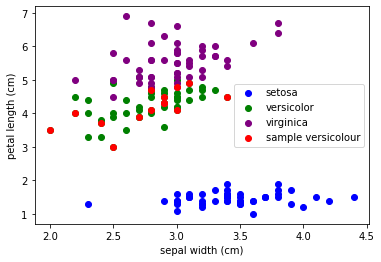

In [3]:
x = X_test[clf.predict(X_test) == 1]
x = x.reshape((1,-1)) if len(x.shape) == 1 else x
palette = ['blue', 'green', 'purple']
for i in range(3):
    species = X[y==i]
    plt.scatter(species[:,1], species[:,2], c=palette[i], label=iris.target_names[i])
plt.scatter(x[:,1], x[:,2], c='red', label='sample versicolour')
plt.xlabel(iris['feature_names'][1])
plt.ylabel(iris['feature_names'][2])
plt.legend()
plt.show()

Compute the G-SHAP values, where $g$ is `ProbabilityDistance`. `ProbabilityDistance` measures the probability that every observation in our sample $x$ was generated by a positive distribution, rather than a negative distribution.

Here, the positive distribution equals 1 for Versicolour and 0 otherwise; $p(\hat{y})=\mathbf{1}(\hat{y}=\text{Versicolour})$. The negative distribution equals 1 for Setosa and 0 otherwise. Intuitively, this analysis asks which features distinguish Versicolour from Setosa.

In [4]:
# Versicolour (1) versus Setosa (0)
pos_distribution = lambda y_pred: y_pred[:,1]
neg_distribution = lambda y_pred: y_pred[:,0]
g = ProbabilityDistance(pos_distribution, neg_distribution)
explainer = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_10 = explainer.gshap_values(x, nsamples=10000)

For interpretation, we compare our sample to the background dataset in terms of $g$. We see that our sample is more likely to have been generated by the positive distribution, rather than the negative distribution, compared with the background dataset.

The sum of the G-SHAP values should approximately equal the difference between our sample and the background data (allowing for sampling error).

In [5]:
g_comparison, g_background = explainer.compare(x, bootstrap_samples=10000)
print('Probability that our sample follows the positive distribution: %.4f' % g_comparison)
print('Probability that the background data follows the positive distribution: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_10.sum())

Probability that our sample follows the positive distribution: 1.0000
Probability that the background data follows the positive distribution: 0.8247
Sum of G-SHAP values: 0.1823


For comparison, we rerun our analysis with the negative distribution equal to 1 for Virginica and 0 otherwise. Intuitively, this analysis asks which features distinguish Versicolour from Viriginica.

In [6]:
# Versicolour (1) versus Virginica (2)
neg_distribution = lambda y_pred: y_pred[:,2]
g = ProbabilityDistance(pos_distribution, neg_distribution)
explainer = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_12 = explainer.gshap_values(x, nsamples=10000)

In [7]:
g_comparison, g_background = explainer.compare(x, bootstrap_samples=10000)
print('Probability that our sample follows the positive distribution: %.4f' % g_comparison)
print('Probability that the background data follows the positive distribution: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_12.sum())

Probability that our sample follows the positive distribution: 1.0000
Probability that the background data follows the positive distribution: 0.4729
Sum of G-SHAP values: 0.5266


Finally, we plot our results. This plot tells us which features best distinguish Versicolour from Setosa (blue) and which features best distinguish Versicolour from Virginia (orange).

More precisely, our model predicts that every iris in our sample $x$ is Versicolour, as opposed to Setosa or Virginica, with probability $p_s$, and that every iris in the background dataset is Versicolour with probability $p_b$. Each G-SHAP value $\phi_j$ is the number of percentage points of this difference $p_s-p_b$ explained by feature $j$.

For our plot, we normalize the G-SHAP values to compare feature importances for distinguishing Versicolour from Setosa, as opposed to Versicolour from Viginica.

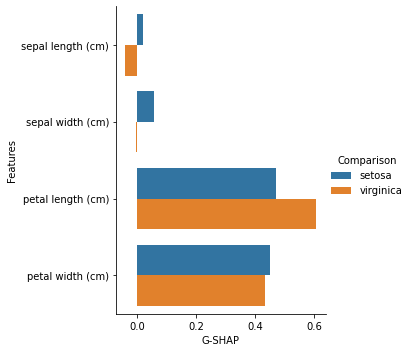

In [8]:
df = pd.DataFrame({
    'Features': iris['feature_names']*2,
    'G-SHAP': list(gshap_values_10/gshap_values_10.sum()) + list(gshap_values_12/gshap_values_12.sum()), 
    'Comparison': [iris['target_names'][0]]*4 + [iris['target_names'][2]]*4
})
sns.catplot(
    x='G-SHAP', 
    y='Features', 
    hue='Comparison', 
    data=df, 
    kind='bar',
    orient='h'
)
plt.show()